# Convolution Neural Net (CNN)
to detect apples

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import modules.cosmos_functions as cf

import pprint
import random
import torch
import torchvision
import torch.nn.functional as FF
import torchvision.transforms.functional as F
import torchvision.transforms as T
import wandb

from datetime import datetime
from os import listdir, path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from tqdm import tqdm

In [2]:
# set the device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
x = torch.ones(1, device=device)

print(f"Device is '{device}' Thus a tensor will look like this: {x}")

Device is 'mps' Thus a tensor will look like this: tensor([1.], device='mps:0')


In [3]:
# function to show an image from the dataloader with its label
def show_batch(train_d,test_d,val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_test = next(iter(test_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][0]
    image_test = data_test[0][0]
    image_val = data_val[0][0]
    label_train = data_train[1][0]
    label_test = data_test[1][0]
    label_val = data_val[1][0]
  

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3)


    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()
    

        # Display the original image in the first subplot
    axes[0].imshow(np_image_train)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the pooled image in the second subplot
    axes[1].imshow(np_image_test)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1].set_title(f'{label_test}, {image_test.shape}')

    # Display the pooled image in the third subplot
    axes[2].imshow(np_image_val)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[2].set_title(f'{label_val}, {image_val.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()

In [4]:
# function to determine accuracy 

def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)

    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()  # PyCharm error Unresolved attribute reference 'float' for class 'bool'
    acc = correct_pred.sum() / len(correct_pred)

    return acc * 100

In [5]:
# function to train the model

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='model.pt'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }   

    # initialize tracker for minimum validation loss
    val_loss_min = np.Inf
    val_acc_min = 0.0

    # loop per epoch
    for epoch in tqdm(range(n_epochs)):
        # initialize tracker for training performance
        train_acc = 0
        train_loss = 0

        ###################
        # train the model #
        ###################

        # prepare model for training
        model.train()

        # loop for each batch
        for data, target in tqdm(train_loader):
            # move data to device
            data, target = data.to(device), target.to(device)
            
            # STEP 1: clear gradients
            optimizer.zero_grad()
            # STEP 2: forward pass
            output = model(data)
            # STEP 3: calculate the loss
            loss = criterion(output, target)
            # STEP 4: backward pass
            loss.backward()
            # STEP 5: perform parameter update
            optimizer.step()
            # STEP 6: accumulate training loss and accuracy
            train_loss += loss.item() * data.size(0)
            acc = evaluate_accuracy(output, target)
            train_acc += acc.item() * data.size(0)

        ######################
        # validate the model #
        ######################

        # disable gradient calculation
        with torch.no_grad():
            # initialize tracker for validation performance
            val_acc = 0
            val_loss = 0

            # prepare model for evaluation
            model.eval()

            # loop for each batch
            for data, target in tqdm(val_loader):
                # move data to device
                data, target = data.to(device), target.to(device)
                # STEP 1: forward pass
                output = model(data)
                # STEP 2: calculate the loss
                loss = criterion(output, target)
                # STEP 3: accumulate validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                val_acc += acc.item() * data.size(0)

        ####################
        # model evaluation #
        ####################

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # calculate average accuracy over an epoch
        train_acc /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # print training progress per epoch
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')

        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(
                f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            model_file_name_loss = model_file_name[:-3] + '_loss.pt'
            torch.save(model.state_dict(), model_file_name_loss)
            val_loss_min = val_loss
        
        # save model if validation accuracy has decreased
        if val_acc >= val_acc_min:
            print(
                f'Validation accuracy increased ({val_acc_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            model_file_name_acc = model_file_name[:-3] + '_acc.pt'  
            torch.save(model.state_dict(), model_file_name_acc)
            val_acc_min = val_acc

        print()

    # return model performance history
    return history

In [6]:
# resize all the images in folder and subfolders ../storage/images/apple_disease_classification

import os

from PIL import Image, ImageOps

resizeshape = 64

for subdir, dirs, files in os.walk("../storage/images/apple_disease_classification"):
    for file in files:
        filepath = subdir + os.sep + file

        # to-do pre-check for all image filetypes
        if filepath.endswith(".jpg") or filepath.endswith(".jpeg"):
            img = Image.open(filepath)
            if img.size != (resizeshape,resizeshape):
                # had to delete one because the jpg was not parseable somehow, blotch #17 is png ipv jpg look into it later
                rgb_im = img.convert('RGB')
                rgb_im_resized = rgb_im.resize(
                    (resizeshape, resizeshape))  # lets try 128x128
                rgb_im_resized.save(filepath)

                ## Quick way to augment dataset by flipping and mirroring
                rgb_im_flipped = ImageOps.flip(rgb_im_resized)
                rgb_im_mirrored = ImageOps.mirror(rgb_im_resized)

                # Modify the file path to include 'flipped' before the extension
                name, extension = os.path.splitext(filepath)
                flipped_filepath = name + '_flipped' + extension
                mirrored_filepath = name + '_mirrored' + extension

In [7]:
# load the dataset
dataset_path = "../storage/images/apple_disease_classification/Train"
transform = T.ToTensor()
dataset = ImageFolder(dataset_path, transform=transform)



dataset.class_to_idx
pp = pprint.PrettyPrinter(indent=1)  # Create a PrettyPrinter instance with an indentation of 1 space
pp.pprint(dataset.class_to_idx)  # Use the pprint method to print the dictionary

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}


torch.Size([3, 64, 64])


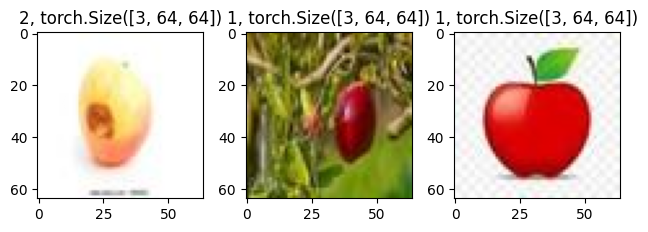

tensor([[[0.8627, 0.7216, 0.5686,  ..., 0.6824, 0.6196, 0.5725],
         [0.6039, 0.5961, 0.5569,  ..., 0.6510, 0.6000, 0.5882],
         [0.4706, 0.5176, 0.5176,  ..., 0.6392, 0.5961, 0.6039],
         ...,
         [0.7216, 0.6980, 0.6824,  ..., 0.2235, 0.2157, 0.2118],
         [0.6941, 0.6667, 0.6588,  ..., 0.2353, 0.2510, 0.2549],
         [0.6941, 0.6667, 0.6667,  ..., 0.2784, 0.2471, 0.2431]],

        [[0.7725, 0.6314, 0.4784,  ..., 0.6863, 0.6314, 0.5843],
         [0.5294, 0.5216, 0.4824,  ..., 0.6471, 0.5961, 0.5843],
         [0.4314, 0.4784, 0.4784,  ..., 0.6235, 0.5765, 0.5843],
         ...,
         [0.6431, 0.6196, 0.5961,  ..., 0.1882, 0.1804, 0.1765],
         [0.6196, 0.5922, 0.5765,  ..., 0.1882, 0.2157, 0.2196],
         [0.6196, 0.5922, 0.5843,  ..., 0.2314, 0.2118, 0.2078]],

        [[0.4588, 0.3176, 0.1725,  ..., 0.7647, 0.7059, 0.6588],
         [0.2314, 0.2235, 0.1843,  ..., 0.7020, 0.6510, 0.6392],
         [0.1608, 0.2078, 0.2078,  ..., 0.6275, 0.5922, 0.

In [8]:
# create the test, train and validation set and the dataloader

# setup split data 
dataset_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


# Set the seed for the generator
seed = 42
generator = torch.Generator().manual_seed(seed)

# Calculate the number of samples for each split
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)


# Define the batch size for the DataLoader
batch_size = 64

# Create the DataLoader to load the dataset in batches
train_d = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_d = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_d = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# print the shape of the 1st image in the dataset
print(train_dataset[0][0].shape)

# Show the 1st img in the dataset
show_batch(train_d, test_d,val_d)
print(train_dataset[0][0])

In [9]:
# define the CNN model

class CNN(nn.Module):
    
    #-------------------------------------------------------
    
    def __init__(self, dropout=0):
        self.dropout = dropout
        

        # Because we inherit from Module base class
        super().__init__()
        
        # RGB input, 6 filters, kernel of 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Filter is 2 x 2 with a stride of 2 (defined once, used two times)
        self.pool = nn.MaxPool2d(2, 2)
        
        # in_channels = 6 because self.conv1 output has 6 channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layer matched on output of conv2 layer
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        
        # Dropout layer1
        self.dropout1 = nn.Dropout(self.dropout)    

        # Dropout layer2
        self.dropout2 = nn.Dropout(self.dropout)

        # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # We only have 2 labels
        self.fc3 = nn.Linear(84, 10)
        
    #-------------------------------------------------------
        
    def forward(self, x):
        
        # Convolution with relu layers
        x = self.pool(FF.relu(self.conv1(x)))
        x = self.pool(FF.relu(self.conv2(x)))
        
        # To match the output of the conv2 layer onto the first fully connected layer
        # Like reshape() but makes no copy (reuses underlaying data)
        x = x.view(-1, 16 * 13 * 13)
        
        # Fully connected layers
        x = FF.relu(self.fc1(x))
        x = self.dropout1(x)
        x = FF.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # No activation on final layer 
        return self.fc3(x)


In [10]:
# set the hyperparameters and the model

# hyperparameters
learning_rate = 0.01
epochs = 35
momentum = 0.9
total_epochs =0
dropout = 0.2


# model parameters

model = CNN(dropout=dropout) # Create the model
model.to(device) # set model to device
model.train() # set model to train mode

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# loss function
criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
 # set the loaders to the correct names for the training loop
train_loader = train_d
val_loader = val_d

# set epochloss to empty list
epoch_loss = []

In [11]:
# create dictionairies for the hyperparameters and model parameters
hyperparameters = { 'learning_rate' : learning_rate, 'epochs' : epochs, 'momentum' : momentum, 'dropout' : dropout}
model_parameters = { 'model' : 'cnn', 'optimizer' : 'SGD', 'criterion' : 'CrossEntropyLoss'}  # 'model' : model, 'optimizer' : optimizer, 'criterion' : criterion
parameters = {**hyperparameters, **model_parameters}    # merge the two dictionairies
pp = pprint.PrettyPrinter(indent=1)  

pp.pprint(f'hyperparameters: {hyperparameters}')
print()
pp.pprint(f'model_parameters: {model_parameters}')
print()
pp.pprint(f'parameters: {parameters}')

("hyperparameters: {'learning_rate': 0.01, 'epochs': 35, 'momentum': 0.9, "
 "'dropout': 0.2}")

("model_parameters: {'model': 'cnn', 'optimizer': 'SGD', 'criterion': "
 "'CrossEntropyLoss'}")

("parameters: {'learning_rate': 0.01, 'epochs': 35, 'momentum': 0.9, "
 "'dropout': 0.2, 'model': 'cnn', 'optimizer': 'SGD', 'criterion': "
 "'CrossEntropyLoss'}")


In [12]:
# the training loop
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
userAccountID = cf.settings['userAccountID']
saveFileName = f'{timestamp}_{userAccountID}.pt'

history = train(
    model, train_loader, val_loader, criterion, optimizer, n_epochs=epochs,
    model_file_name=saveFileName
)

  3%|▎         | 1/35 [00:17<09:56, 17.56s/it]

Epoch 001 | Train Loss: 2.28312 | Val Loss: 2.27100 | Train Acc: 1.12 | Val Acc: 10.53
Validation loss decreased (inf --> 2.27100)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (0.00000 --> 2.27100)  Saving model to 20230605-004646_pinky.pt...



  6%|▌         | 2/35 [00:34<09:33, 17.39s/it]

Epoch 002 | Train Loss: 2.24548 | Val Loss: 2.21969 | Train Acc: 23.97 | Val Acc: 17.54
Validation loss decreased (2.27100 --> 2.21969)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (10.52632 --> 2.21969)  Saving model to 20230605-004646_pinky.pt...



  9%|▊         | 3/35 [00:52<09:14, 17.32s/it]

Epoch 003 | Train Loss: 2.18605 | Val Loss: 2.15482 | Train Acc: 25.47 | Val Acc: 28.07
Validation loss decreased (2.21969 --> 2.15482)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (17.54386 --> 2.15482)  Saving model to 20230605-004646_pinky.pt...



 11%|█▏        | 4/35 [01:09<08:56, 17.29s/it]

Epoch 004 | Train Loss: 2.11412 | Val Loss: 2.08612 | Train Acc: 29.21 | Val Acc: 28.07
Validation loss decreased (2.15482 --> 2.08612)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (28.07018 --> 2.08612)  Saving model to 20230605-004646_pinky.pt...



 14%|█▍        | 5/35 [01:26<08:38, 17.28s/it]

Epoch 005 | Train Loss: 2.03931 | Val Loss: 2.01596 | Train Acc: 29.21 | Val Acc: 28.07
Validation loss decreased (2.08612 --> 2.01596)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (28.07018 --> 2.01596)  Saving model to 20230605-004646_pinky.pt...



 17%|█▋        | 6/35 [01:43<08:20, 17.27s/it]

Epoch 006 | Train Loss: 1.95904 | Val Loss: 1.93938 | Train Acc: 28.46 | Val Acc: 28.07
Validation loss decreased (2.01596 --> 1.93938)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (28.07018 --> 1.93938)  Saving model to 20230605-004646_pinky.pt...



 20%|██        | 7/35 [02:01<08:03, 17.27s/it]

Epoch 007 | Train Loss: 1.86840 | Val Loss: 1.82526 | Train Acc: 26.59 | Val Acc: 28.07
Validation loss decreased (1.93938 --> 1.82526)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (28.07018 --> 1.82526)  Saving model to 20230605-004646_pinky.pt...



 23%|██▎       | 8/35 [02:18<07:46, 17.27s/it]

Epoch 008 | Train Loss: 1.70578 | Val Loss: 1.52883 | Train Acc: 29.59 | Val Acc: 28.07
Validation loss decreased (1.82526 --> 1.52883)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (28.07018 --> 1.52883)  Saving model to 20230605-004646_pinky.pt...



 26%|██▌       | 9/35 [02:35<07:28, 17.26s/it]

Epoch 009 | Train Loss: 1.47443 | Val Loss: 1.49260 | Train Acc: 25.09 | Val Acc: 28.07
Validation loss decreased (1.52883 --> 1.49260)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (28.07018 --> 1.49260)  Saving model to 20230605-004646_pinky.pt...



 29%|██▊       | 10/35 [02:52<07:11, 17.27s/it]

Epoch 010 | Train Loss: 1.50952 | Val Loss: 1.37738 | Train Acc: 23.60 | Val Acc: 31.58
Validation loss decreased (1.49260 --> 1.37738)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (28.07018 --> 1.37738)  Saving model to 20230605-004646_pinky.pt...



 31%|███▏      | 11/35 [03:10<06:54, 17.26s/it]

Epoch 011 | Train Loss: 1.45724 | Val Loss: 1.45498 | Train Acc: 29.21 | Val Acc: 28.07



 34%|███▍      | 12/35 [03:27<06:36, 17.26s/it]

Epoch 012 | Train Loss: 1.44109 | Val Loss: 1.58599 | Train Acc: 27.72 | Val Acc: 10.53



 37%|███▋      | 13/35 [03:44<06:19, 17.25s/it]

Epoch 013 | Train Loss: 1.41057 | Val Loss: 1.43963 | Train Acc: 29.21 | Val Acc: 29.82



 40%|████      | 14/35 [04:01<06:02, 17.26s/it]

Epoch 014 | Train Loss: 1.35135 | Val Loss: 1.31272 | Train Acc: 31.84 | Val Acc: 43.86
Validation loss decreased (1.37738 --> 1.31272)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (31.57895 --> 1.31272)  Saving model to 20230605-004646_pinky.pt...



 43%|████▎     | 15/35 [04:19<05:44, 17.25s/it]

Epoch 015 | Train Loss: 1.31368 | Val Loss: 1.33742 | Train Acc: 40.45 | Val Acc: 50.88
Validation accuracy increased (43.85965 --> 1.33742)  Saving model to 20230605-004646_pinky.pt...



 46%|████▌     | 16/35 [04:36<05:28, 17.26s/it]

Epoch 016 | Train Loss: 1.32080 | Val Loss: 1.25905 | Train Acc: 36.33 | Val Acc: 45.61
Validation loss decreased (1.31272 --> 1.25905)  Saving model to 20230605-004646_pinky.pt...



 49%|████▊     | 17/35 [04:53<05:10, 17.26s/it]

Epoch 017 | Train Loss: 1.26748 | Val Loss: 1.22875 | Train Acc: 41.57 | Val Acc: 38.60
Validation loss decreased (1.25905 --> 1.22875)  Saving model to 20230605-004646_pinky.pt...



 51%|█████▏    | 18/35 [05:10<04:53, 17.26s/it]

Epoch 018 | Train Loss: 1.27095 | Val Loss: 1.30880 | Train Acc: 36.70 | Val Acc: 29.82



 54%|█████▍    | 19/35 [05:28<04:36, 17.25s/it]

Epoch 019 | Train Loss: 1.25103 | Val Loss: 1.29273 | Train Acc: 41.95 | Val Acc: 47.37



 57%|█████▋    | 20/35 [05:45<04:18, 17.26s/it]

Epoch 020 | Train Loss: 1.21431 | Val Loss: 1.26428 | Train Acc: 45.69 | Val Acc: 49.12



 60%|██████    | 21/35 [06:02<04:01, 17.28s/it]

Epoch 021 | Train Loss: 1.19284 | Val Loss: 1.25865 | Train Acc: 46.07 | Val Acc: 36.84



 63%|██████▎   | 22/35 [06:20<03:44, 17.28s/it]

Epoch 022 | Train Loss: 1.24334 | Val Loss: 1.31117 | Train Acc: 40.82 | Val Acc: 45.61



 66%|██████▌   | 23/35 [06:37<03:27, 17.27s/it]

Epoch 023 | Train Loss: 1.22035 | Val Loss: 1.21178 | Train Acc: 44.94 | Val Acc: 52.63
Validation loss decreased (1.22875 --> 1.21178)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (50.87720 --> 1.21178)  Saving model to 20230605-004646_pinky.pt...



 69%|██████▊   | 24/35 [06:54<03:09, 17.27s/it]

Epoch 024 | Train Loss: 1.15475 | Val Loss: 1.12726 | Train Acc: 50.19 | Val Acc: 50.88
Validation loss decreased (1.21178 --> 1.12726)  Saving model to 20230605-004646_pinky.pt...



 71%|███████▏  | 25/35 [07:11<02:52, 17.27s/it]

Epoch 025 | Train Loss: 1.12232 | Val Loss: 1.24010 | Train Acc: 48.69 | Val Acc: 45.61



 74%|███████▍  | 26/35 [07:29<02:35, 17.30s/it]

Epoch 026 | Train Loss: 1.14094 | Val Loss: 1.11839 | Train Acc: 50.94 | Val Acc: 47.37
Validation loss decreased (1.12726 --> 1.11839)  Saving model to 20230605-004646_pinky.pt...



 77%|███████▋  | 27/35 [07:46<02:18, 17.30s/it]

Epoch 027 | Train Loss: 1.11389 | Val Loss: 1.04968 | Train Acc: 50.19 | Val Acc: 49.12
Validation loss decreased (1.11839 --> 1.04968)  Saving model to 20230605-004646_pinky.pt...



 80%|████████  | 28/35 [08:03<02:01, 17.32s/it]

Epoch 028 | Train Loss: 1.09363 | Val Loss: 1.05355 | Train Acc: 55.06 | Val Acc: 47.37



 83%|████████▎ | 29/35 [08:21<01:44, 17.34s/it]

Epoch 029 | Train Loss: 1.07441 | Val Loss: 1.07595 | Train Acc: 52.43 | Val Acc: 47.37



 86%|████████▌ | 30/35 [08:38<01:26, 17.33s/it]

Epoch 030 | Train Loss: 1.01798 | Val Loss: 1.14602 | Train Acc: 57.30 | Val Acc: 50.88



 89%|████████▊ | 31/35 [08:55<01:09, 17.32s/it]

Epoch 031 | Train Loss: 1.02228 | Val Loss: 0.99613 | Train Acc: 55.81 | Val Acc: 52.63
Validation loss decreased (1.04968 --> 0.99613)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (52.63158 --> 0.99613)  Saving model to 20230605-004646_pinky.pt...



 91%|█████████▏| 32/35 [09:13<00:51, 17.30s/it]

Epoch 032 | Train Loss: 1.02589 | Val Loss: 1.16245 | Train Acc: 59.18 | Val Acc: 49.12



 94%|█████████▍| 33/35 [09:30<00:34, 17.29s/it]

Epoch 033 | Train Loss: 1.00099 | Val Loss: 1.02902 | Train Acc: 57.30 | Val Acc: 47.37



 97%|█████████▋| 34/35 [09:47<00:17, 17.32s/it]

Epoch 034 | Train Loss: 0.97601 | Val Loss: 1.15451 | Train Acc: 60.67 | Val Acc: 49.12



100%|██████████| 35/35 [10:05<00:00, 17.29s/it]

Epoch 035 | Train Loss: 0.97174 | Val Loss: 0.96090 | Train Acc: 58.80 | Val Acc: 54.39
Validation loss decreased (0.99613 --> 0.96090)  Saving model to 20230605-004646_pinky.pt...
Validation accuracy increased (52.63158 --> 0.96090)  Saving model to 20230605-004646_pinky.pt...



In [13]:
print(f'history: {history}')

history: {'n_epochs': 35, 'train_loss': [2.2831246076005227, 2.2454754377572277, 2.186045182331671, 2.114124068606659, 2.0393088243427346, 1.9590409659267811, 1.8683977569087167, 1.7057786054825514, 1.4744322148155184, 1.5095162266649111, 1.4572397202588199, 1.4410911320747062, 1.4105737535248088, 1.3513492899441093, 1.313683032989502, 1.3207969884300945, 1.2674761064043651, 1.2709502499648249, 1.251034042808447, 1.214309497718954, 1.192839287193527, 1.2433387576864008, 1.2203502029961861, 1.1547465601217435, 1.1223229587301333, 1.140944263015347, 1.113893939761187, 1.0936285391282499, 1.0744143005613978, 1.0179828767026409, 1.0222781318403809, 1.025889710094152, 1.0009946582022677, 0.9760119401560294, 0.9717422670192932], 'val_loss': [2.2710013389587402, 2.2196948528289795, 2.154815435409546, 2.086116075515747, 2.015962839126587, 1.939375638961792, 1.8252589702606201, 1.5288254022598267, 1.4925979375839233, 1.3773846626281738, 1.4549767971038818, 1.585986614227295, 1.439629077911377, 

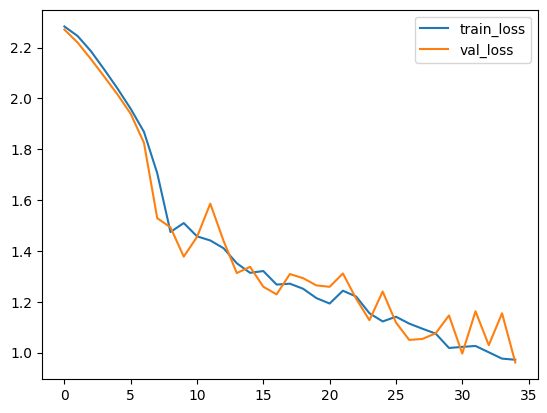

In [17]:
# plot the history bothe the loss as the accuracy side by side

# Plot the training and validation loss
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()


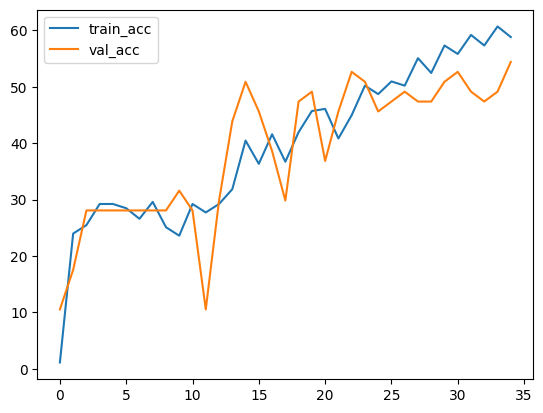

In [18]:

# Plot the training and validation accuracy
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Create a figure with two subplots
# fig, axes = plt.subpl


save the data to azure cosmos NoSQL database


In [21]:


cf.save_data(saveFileName, parameters, history)



FileNotFoundError: [Errno 2] No such file or directory: '../../storage/data/saved/module_test_files/saved/20230602_1600_pinky.pth'

In [ ]:
saveFileName

test


In [ ]:
# loading has broken..
x=cf.load_pth('20230602_1637_pinky')
x

In [ ]:
test_loader = test_d
len(test_loader)

In [ ]:
%%timeit
y_test = []
y_pred = []
counter = 0
# disable gradient calculation
with torch.no_grad():
    # prepare model for evaluation
    model.eval()

    # loop for each data
    for data, target in tqdm(test_loader):
        # move data to device
        data, target = data.to(device), target.to(device)

        counter += 1
        # STEP 1: forward pass
        output = model(data)
        # STEP 2: get predicted label
        _, label = torch.max(output, dim=1)
        # STEP 3: append actual and predicted label
        y_test += target.cpu().numpy().tolist()  # set to cpu and convert to list for old visualisation
        y_pred += label.cpu().numpy().tolist()
        print(counter)

print(f'End{counter}')

In [ ]:
# collapse-hide
plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))